In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
folder = 'time_logs/'
approaches = ['Sellán et al. (2022)', 'Ours']
file = ['sellan_14022024', 'allopezr2024_2_24__12_33_52']
memory_unit = ['B', 'MB', 'MB']
time_unit = ['s', 'ms', 's']
uses_gpu = [False, True, True]
extension = '.txt'
ignore_storable = False

In [15]:
# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 18}
plt.rc('font', **font_mapping)

In [16]:
class Event:
    def __init__(self, time, event_type, time_unit='s'):
        self.time = time
        self.event_type = event_type
        
        # make label pretty
        self.event_type = self.event_type.replace('_', ' ')
        
        # Preserve initial uppercase and lower the rest
        self.event_type = self.event_type[0].upper() + self.event_type[1:].lower()
        
        if time_unit == 'ms':
            self.time /= 1000
        
class ResourceUsage:
    def __init__(self, cpu, cpu_total, memory, memory_total, virtual_memory=.0, virtual_memory_total=.0, gpu=.0, gpu_total=.0, memory_unit='MB'):
        self.cpu = cpu
        self.cpu_total = cpu_total
        self.memory = memory
        self.memory_total = memory_total
        self.virtual_memory = virtual_memory
        self.virtual_memory_total = virtual_memory_total
        self.gpu = gpu
        self.gpu_total = gpu_total
        
        divisor = 1
        if memory_unit == 'GB':
            divisor = 1024
        elif memory_unit == 'MB':
            divisor = 1024 ** 1
        elif memory_unit == 'KB':
            divisor = 1024 ** 2
        elif memory_unit == 'B':
            divisor = 1024 ** 3
            
        self.memory /= divisor
        self.memory_total /= divisor
        self.virtual_memory /= divisor
        self.virtual_memory_total /= divisor
        self.gpu /= divisor
        self.gpu_total /= divisor

In [17]:
def ignore_storage(event_type):
    return 'STORAGE' in event_type or 'SAVE' in event_type

In [18]:
events = []
resource_usage = []

for i in tqdm(range(len(approaches))):
    file_name = folder + file[i] + extension
    print(file_name)

    with open(file_name, 'r') as f:
        lines = f.readlines()
        events.append([])
        resource_usage.append([])
        
        for line in lines:
            if 'EventType.' in line:
                time = float(line.split(' ')[1])
                event_type = line.split(' ')[0]
                if ignore_storable and ignore_storage(event_type):
                    continue
                event_type = event_type.split('.')[1]
                events[i].append(Event(time, event_type))
            elif '*' in line:
                time = float(line.split(':')[1].split(' ')[1])
                event_type = line.split(':')[0].split('*')[1]
                if ignore_storable and ignore_storage(event_type):
                    continue
                event_type = event_type.strip()
                events[i].append(Event(time, event_type, time_unit=time_unit[i]))
            else:
                resources = line.split(' ')
                if len(resources) == 5:
                    cpu = float(resources[0]) / 40.0
                    memory = float(resources[1])
                    memory_total = float(resources[2])
                    virtual_memory = float(resources[3])
                    virtual_memory_total = float(resources[4])
                    resource_usage[i].append(ResourceUsage(cpu, 100.0, memory, memory_total, virtual_memory, virtual_memory_total, memory_unit=memory_unit[i]))
                elif len(resources) == 9:
                    cpu = float(resources[0])
                    cpu_total = float(resources[1])
                    memory = float(resources[2])
                    memory_total = float(resources[3])
                    virtual_memory = float(resources[4])
                    virtual_memory_total = float(resources[5])
                    gpu = float(resources[6])
                    gpu_total = float(resources[7])
                    resource_usage[i].append(ResourceUsage(cpu, cpu_total, memory, memory_total, virtual_memory, virtual_memory_total, gpu, gpu_total, memory_unit[i]))

100%|██████████| 2/2 [00:00<00:00, 16.67it/s]

time_logs/sellan_14022024.txt
time_logs/allopezr2024_2_24__12_33_52.txt


In [19]:
summed_time = [0, 0]
for i in range(len(approaches)):
    for event in events[i]:
        summed_time[i] += event.time
    print(f'{approaches[i]}: {summed_time[i]}')

Sellán et al. (2022): 7340.945189714432
Ours: 2116.4629999999806


In [20]:
def plot_tendency(x, y, color, linestyle='-', ax=None, linewidth=1.5):
    tendency = np.polyfit(x, y, 3)
    if ax is not None:
        ax.plot(x, np.polyval(tendency, x), linestyle=linestyle, color=color, linewidth=linewidth)
    else:
        plt.plot(x, np.polyval(tendency, x), linestyle=linestyle, color=color, linewidth=linewidth)

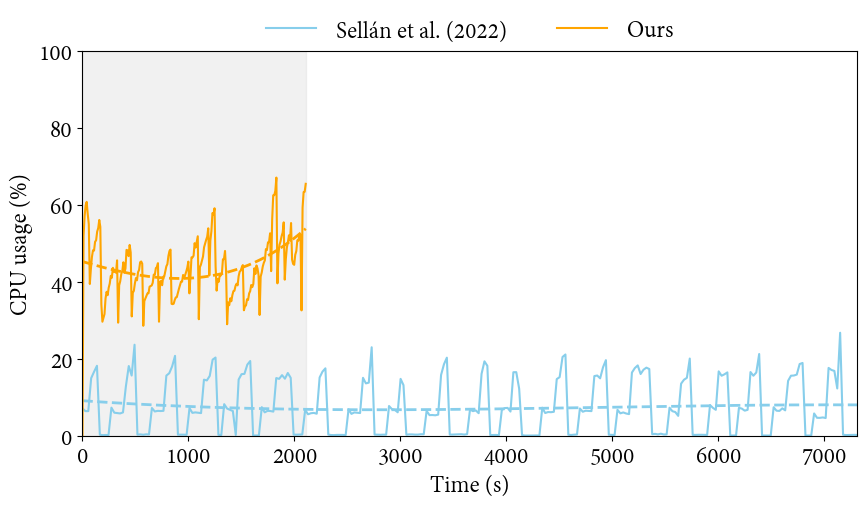

In [21]:
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
x_axes = []

# CPU usage
max_x, min_x = 0, 1e9
plt.figure(figsize=(10, 5))

for i in range(len(approaches)):
    # split summed time into as many intervals as resource usage
    time_interval = summed_time[i] / len(resource_usage[i])
    x_axis = [i * time_interval for i in range(len(resource_usage[i]))]
    max_x = np.amax([max_x, np.amax(x_axis)])
    min_x = np.amin([min_x, np.amax(x_axis)])
    x_axes.append(x_axis)
    
# Shadow chart until min_x
plt.fill_between([0, min_x], 0, 100, color='lightgray', alpha=0.3)

for i in range(len(approaches)):
    plt.plot(x_axes[i], [resource.cpu for resource in resource_usage[i]], colors[i], label=approaches[i], linewidth=1.5)
    plot_tendency(x_axes[i], [resource.cpu for resource in resource_usage[i]], colors[i], linestyle='--', linewidth=2)
    
plt.xlabel('Time (s)')
plt.ylabel('CPU usage (%)')
plt.xlim(0, max_x)
plt.ylim(0, 100) 
plt.legend(frameon=False, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.14))
plt.savefig('cpu_usage.png', dpi=500)
plt.show()

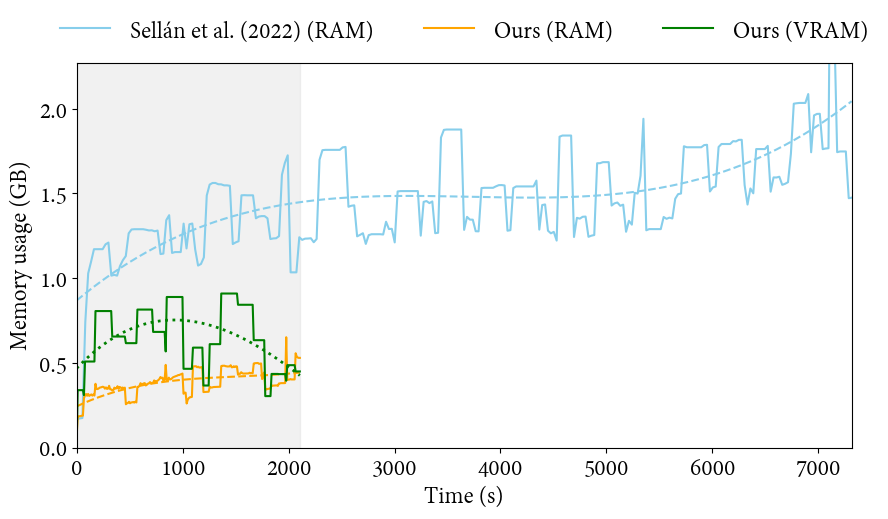

In [22]:
# Memory usage
max_y = 0
plt.figure(figsize=(10, 5))

plt.fill_between([0, min_x], 0, 100, color='lightgray', alpha=0.3)
for i in range(len(approaches)):  
    plt.plot(x_axes[i], [resource.memory for resource in resource_usage[i]], label=approaches[i] + ' (RAM)', color=colors[i], linewidth=1.5)
    plot_tendency(x_axes[i], [resource.memory for resource in resource_usage[i]], colors[i], linestyle='--')
    #plt.plot(x_axis, [resource.virtual_memory for resource in resource_usage[i]], label=approaches[i] + ' (Swap)', linestyle='--', color=colors[i])
    if uses_gpu[i]:
        plt.plot(x_axes[i], [resource.gpu for resource in resource_usage[i]], label=approaches[i] + ' (VRAM)', color=colors[i + 1])
        plot_tendency(x_axes[i], [resource.gpu for resource in resource_usage[i]], colors[i + 1], linestyle=':', linewidth=2)
        
    max_y = np.amax([max_y, np.amax([resource.memory for resource in resource_usage[i]])])

plt.xlabel('Time (s)')
plt.ylabel('Memory usage (GB)')
plt.xlim(0, max_x)
plt.ylim(0, max_y * 0.6)
plt.legend(frameon=False, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.17))
plt.savefig('memory_usage.png', dpi=500)
plt.show()

C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_5188\521314666.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(accumulated_time.keys(), rotation=45)
C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_5188\521314666.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(accumulated_time.keys(), rotation=45)


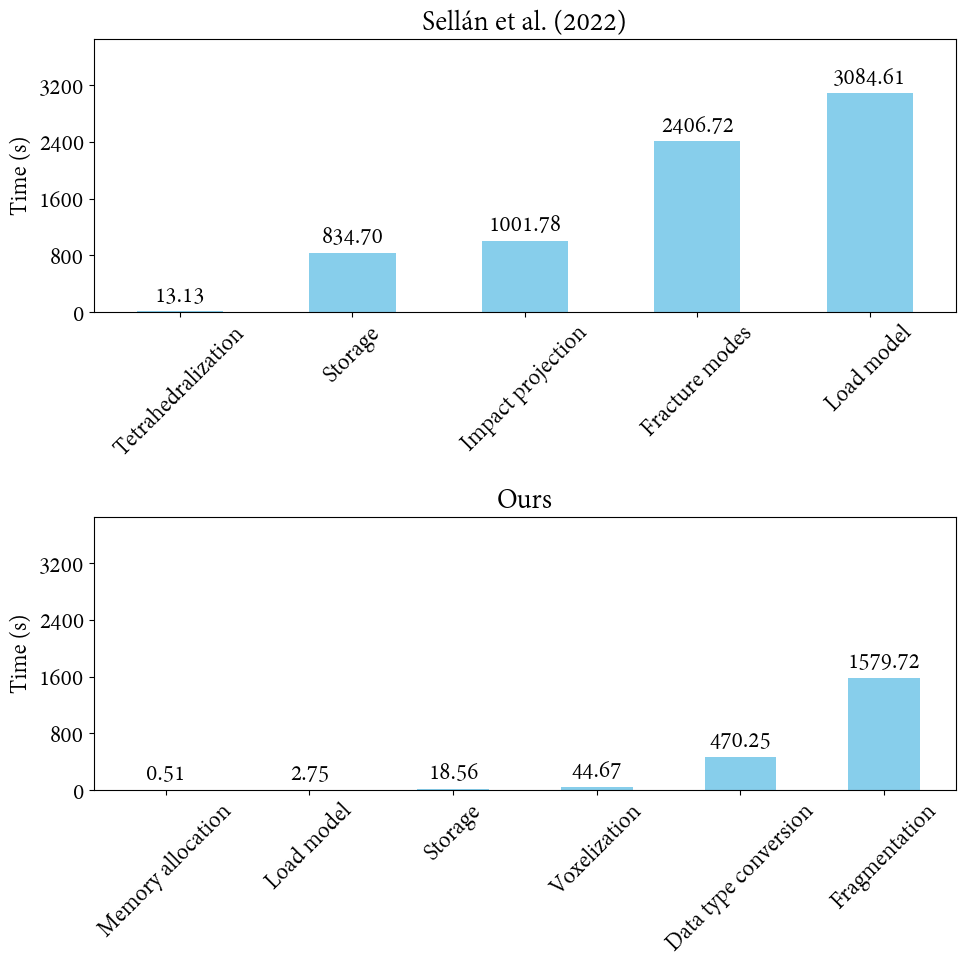

In [23]:
# Grid of size 3x1
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
max_y = 0

for i in range(len(approaches)):
    # how many events do exist for the approach
    unique_events = set([event.event_type for event in events[i]])
    
    accumulated_time = {event: 0 for event in unique_events}
    for event in events[i]:
        accumulated_time[event.event_type] += event.time
        
    # sort
    accumulated_time = dict(sorted(accumulated_time.items(), key=lambda item: item[1]))
    
    ax[i].bar(accumulated_time.keys(), accumulated_time.values(), width=0.5, color='skyblue')
    for event, time in accumulated_time.items():
        ax[i].text(event, time + 50, f'{time:.2f}', ha='center', va='bottom')
        
    ax[i].set_title(approaches[i])
    ax[i].set_ylabel('Time (s)')
    ax[i].set_xticklabels(accumulated_time.keys(), rotation=45)
    ax[i].set_xlim(-0.5, len(unique_events) - 0.5)
    # if i > 0:
    #     ax[i].set_yticklabels([])
    max_y = np.amax([max_y, np.amax(list(accumulated_time.values()))])

for i in range(len(approaches)):
    ax[i].set_ylim(0, max_y * 1.25)
    ax[i].set_yticks(np.arange(0, max_y * 1.2, 800))
    
plt.tight_layout()
plt.savefig('event_distribution.png', dpi=500)
plt.show()

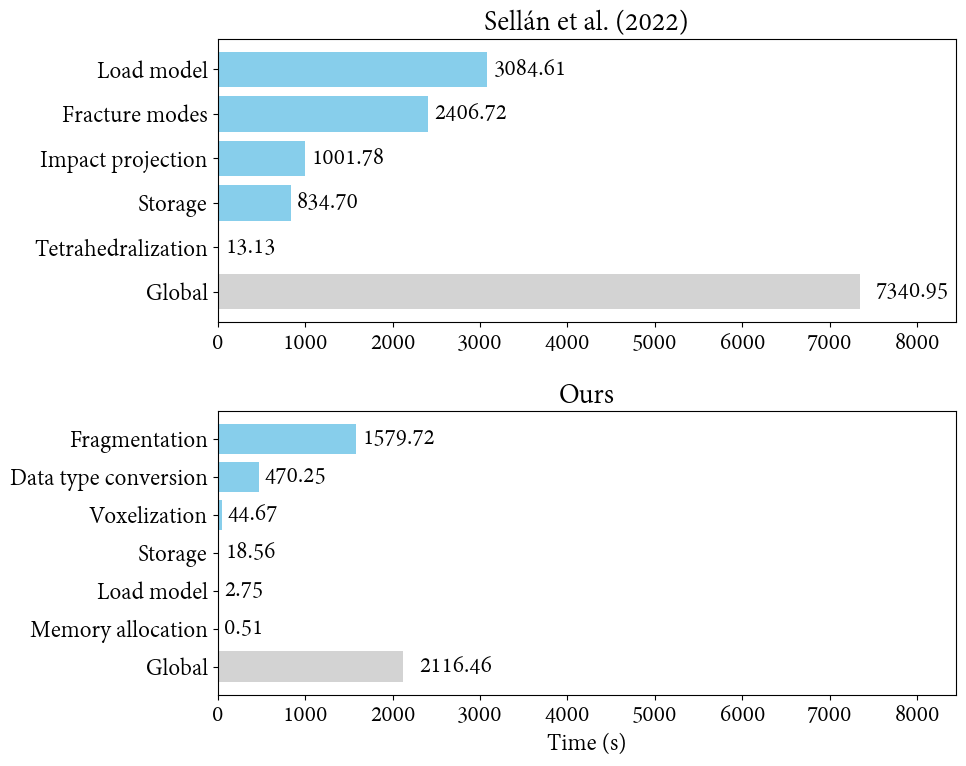

In [24]:
# Grid of size 2x1
# Events, displayed as horizontal bar chart
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
max_x = 0

for i in range(len(approaches)):
    # Display as an stacked horizontal bar chart
    unique_events = set([event.event_type for event in events[i]])
    accumulated_time = {event: 0 for event in unique_events}
    for event in events[i]:
        accumulated_time[event.event_type] += event.time
        
    # sort
    accumulated_time = dict(sorted(accumulated_time.items(), key=lambda item: item[1]))
    
    # add global time
    ax[i].barh('Global', summed_time[i], color='lightgray') 
    ax[i].text(summed_time[i] + 600, 'Global', f'{summed_time[i]:.2f}', ha='center', va='center')
    
    ax[i].barh(list(accumulated_time.keys()), list(accumulated_time.values()), color='skyblue')
    for event, time in accumulated_time.items():
        ax[i].text(time + 70, event, f'{time:.2f}', ha='left', va='center')
    
    ax[i].set_title(approaches[i])
    if i > 0:
        ax[i].set_xlabel('Time (s)')
    
    max_x = np.amax([max_x, summed_time[i]])
    
for i in range(len(approaches)):
    ax[i].set_xlim(0, max_x * 1.15)
    
plt.tight_layout()
plt.savefig('event_distribution_horizontal.png', dpi=500)
plt.show()